Importing required packages

In [48]:
import  pandas as  pd
import  numpy  as  np
import  xgboost as xgb
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score,roc_curve
from sklearn.metrics import auc
%matplotlib inline

Dataset link

https://www.kaggle.com/wendykan/lending-club-loan-data

Read data from csv

In [4]:
data = pd.read_csv("loan.csv", sep=",", error_bad_lines=False, low_memory=False,
                   parse_dates=["issue_d", "earliest_cr_line", "last_pymnt_d",
                                "next_pymnt_d", "last_credit_pull_d"])
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Preprocessing data

In [5]:
data.isnull().sum() #looking for null values

id                                  0
member_id                           0
loan_amnt                           0
funded_amnt                         0
funded_amnt_inv                     0
term                                0
int_rate                            0
installment                         0
grade                               0
sub_grade                           0
emp_title                       51462
emp_length                      44825
home_ownership                      0
annual_inc                          4
verification_status                 0
issue_d                             0
loan_status                         0
pymnt_plan                          0
url                                 0
desc                           761351
purpose                             0
title                             152
zip_code                            0
addr_state                          0
dti                                 0
delinq_2yrs                        29
earliest_cr_

In [22]:
cleaned_data = data[[label for label in data if data[label].isnull().sum() <= 0.01 * data.shape[0]]] #only taking columns where less than 1% are null values

In [23]:
cleaned_data.isnull().sum() #checking null values of selected columns

id                              0
member_id                       0
loan_amnt                       0
funded_amnt                     0
funded_amnt_inv                 0
term                            0
int_rate                        0
installment                     0
grade                           0
sub_grade                       0
home_ownership                  0
annual_inc                      4
verification_status             0
issue_d                         0
loan_status                     0
pymnt_plan                      0
url                             0
purpose                         0
title                         152
zip_code                        0
addr_state                      0
dti                             0
delinq_2yrs                    29
earliest_cr_line               29
inq_last_6mths                 29
open_acc                       29
pub_rec                        29
revol_bal                       0
revol_util                    502
total_acc     

In [24]:
cleaned_data = cleaned_data.dropna() #dropping rows with null values since the amount is insignificant

Selecting features

In [25]:
pd.options.display.max_columns = None #show all columns
cleaned_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,other,personel,917xx,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,RENT,80000.0,Source Verified,2011-12-01,Current,n,https://www.lendingclub.com/browse/loanDetail....,other,Personal,972xx,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


In [26]:
cleaned_data = cleaned_data.drop(["id", "member_id", "sub_grade", "url", "zip_code", "title"], axis=1)
#id, member_id and url are identifiers which can be dropped
#sub_grade is redundant with int_rate and grade
#title is unformatted and can be dropped
#zip_code is redundant with addr_state
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,1.0,INDIVIDUAL,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,1.0,INDIVIDUAL,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,1.0,INDIVIDUAL,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,RENT,80000.0,Source Verified,2011-12-01,Current,n,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,1.0,INDIVIDUAL,0.0


In [13]:
#checking for columns with insignificant frequencies
for label in list(cleaned_data):
    if len(cleaned_data[label].unique()) < 4:
        print(cleaned_data[label].value_counts())
        print("\n")

 36 months    620486
 60 months    266076
Name: term, dtype: int64


Source Verified    329332
Verified           290834
Not Verified       266396
Name: verification_status, dtype: int64


n    886552
y        10
Name: pymnt_plan, dtype: int64


f    456363
w    430199
Name: initial_list_status, dtype: int64


1.0    886562
Name: policy_code, dtype: int64


INDIVIDUAL    886060
JOINT            502
Name: application_type, dtype: int64




In [27]:
cleaned_data = cleaned_data.drop(["pymnt_plan", "policy_code", "application_type"], axis=1)
#pymnt_plan and application_type are skewed to one majority class and can be dropped
#policy_code only has one unique value
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,RENT,24000.0,Verified,2011-12-01,Fully Paid,credit_card,AZ,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,0.0
1,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,RENT,30000.0,Source Verified,2011-12-01,Charged Off,car,GA,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,0.0
2,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,small_business,IL,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,0.0
3,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,other,CA,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,f,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,0.0
4,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,RENT,80000.0,Source Verified,2011-12-01,Current,other,OR,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,0.0


Mapping values

In [28]:
list(cleaned_data["loan_status"].unique()) #checking unique values of label column

['Fully Paid',
 'Charged Off',
 'Current',
 'Default',
 'Late (31-120 days)',
 'In Grace Period',
 'Late (16-30 days)',
 'Does not meet the credit policy. Status:Fully Paid',
 'Does not meet the credit policy. Status:Charged Off',
 'Issued']

Since this model will predict loan default, 'Charged Off', 'Default', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off' will all be mapped to 1 (default). The rest of the values will be mapped to 0 (not default).

In [29]:
#define function to map loan values
def target_mapping(uniqueloanvalues):
    mapping = {}
    for elem in uniqueloanvalues:
        if elem in ["Default", "Charged Off", "Late (31-120 days)",
                   "Does not meet the credit policy. Status:Charged Off"]:
            mapping[elem] = 1
        else:
            mapping[elem] = 0
    return mapping

In [30]:
cleaned_data["loan_status"] = cleaned_data["loan_status"].map(target_mapping(cleaned_data["loan_status"].unique())) #map loan_status

Categorical features to numerical values

In [31]:
cleaned_data.select_dtypes(include=["object"]).head() #showing object columns

,term,grade,home_ownership,verification_status,purpose,addr_state,initial_list_status
0,36 months,B,RENT,Verified,credit_card,AZ,f
1,60 months,C,RENT,Source Verified,car,GA,f
2,36 months,C,RENT,Not Verified,small_business,IL,f
3,36 months,C,RENT,Source Verified,other,CA,f
4,60 months,B,RENT,Source Verified,other,OR,f


In [32]:
#label encode into categories
le = preprocessing.LabelEncoder()
for column_name in cleaned_data.select_dtypes(include=["object"]).columns: #selecting categorical columns to label encode
    cleaned_data[column_name] = le.fit_transform(cleaned_data[column_name])
cleaned_data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,acc_now_delinq
0,5000.0,5000.0,4975.0,0,10.65,162.87,1,5,24000.0,2,2011-12-01,0,1,3,27.65,0.0,1985-01-01,1.0,3.0,0.0,13648.0,83.7,9.0,0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,171.62,2016-01-01,0.0,0.0
1,2500.0,2500.0,2500.0,1,15.27,59.83,2,5,30000.0,1,2011-12-01,1,0,10,1.00,0.0,1999-04-01,5.0,3.0,0.0,1687.0,9.4,4.0,0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,119.66,2013-09-01,0.0,0.0
2,2400.0,2400.0,2400.0,0,15.96,84.33,2,5,12252.0,0,2011-12-01,0,11,14,8.72,0.0,2001-11-01,2.0,2.0,0.0,2956.0,98.5,10.0,0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,649.91,2016-01-01,0.0,0.0
3,10000.0,10000.0,10000.0,0,13.49,339.31,2,5,49200.0,1,2011-12-01,0,9,4,20.00,0.0,1996-02-01,1.0,10.0,0.0,5598.0,21.0,37.0,0,0.0,0.0,12226.302212,12226.30,10000.00,2209.33,16.97,0.00,0.00,357.48,2015-01-01,0.0,0.0
4,3000.0,3000.0,3000.0,1,12.69,67.79,1,5,80000.0,1,2011-12-01,0,9,37,17.94,0.0,1996-01-01,0.0,15.0,0.0,27783.0,53.9,38.0,0,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,67.79,2016-01-01,0.0,0.0


Datetime features

In [33]:
cleaned_data.select_dtypes(include=["datetime"]).head()

,issue_d,earliest_cr_line,last_credit_pull_d
0,2011-12-01,1985-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-09-01
2,2011-12-01,2001-11-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01


In [ ]:
#creating two new month and year columns for each datetime feature
datetime_features = list(cleaned_data.select_dtypes(include=["datetime"]))

for label in datetime_features:   
    cleaned_data[label + "_year"] = cleaned_data[label].dt.year
    cleaned_data[label + "_month"] = cleaned_data[label].dt.month
    
cleaned_data = cleaned_data.drop(datetime_features, axis=1)

In [36]:
cleaned_data.shape

(886562, 40)

886562 rows and 40 columns (39 features and 1 label) to train the model.

Training model

In [37]:
#creating x:features and y:labels dataframes using function
def get_xy(df, y_label):
    y = df[y_label]
    x = df.drop(y_label, axis=1)
    return x, y

In [38]:
x, y = get_xy(cleaned_data, "loan_status")

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size=0.2) #stratified split on dataset for taining and test

In [41]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2) #splitting training set into training and validation set

In [42]:
#training, validation and testing matrices
dtrain = xgb.DMatrix(x_train, y_train)
dval = xgb.DMatrix(x_val, y_val)
dtest = xgb.DMatrix(x_test)
#intialize parameters
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'silent': 1
}
#intialize model
partial_model = xgb.train(xgb_params, dtrain, num_boost_round=10000, evals=[(dval, 'val')], 
                          early_stopping_rounds=20, verbose_eval=20)
#select ideal iterations from validation results
num_boost_round = partial_model.best_iteration
#train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_round)
#testing
y_test_xgb = model.predict(dtest)

[0]	val-auc:0.938809
Will train until val-auc hasn't improved in 20 rounds.
[20]	val-auc:0.951113
[40]	val-auc:0.953164
[60]	val-auc:0.954751
[80]	val-auc:0.962069
[100]	val-auc:0.966907
[120]	val-auc:0.971045
[140]	val-auc:0.975699
[160]	val-auc:0.979689
[180]	val-auc:0.98271
[200]	val-auc:0.984818
[220]	val-auc:0.986573
[240]	val-auc:0.98792
[260]	val-auc:0.989259
[280]	val-auc:0.990202
[300]	val-auc:0.990985
[320]	val-auc:0.991903
[340]	val-auc:0.992581
[360]	val-auc:0.993105
[380]	val-auc:0.993621
[400]	val-auc:0.993966
[420]	val-auc:0.994361
[440]	val-auc:0.994648
[460]	val-auc:0.994895
[480]	val-auc:0.995162
[500]	val-auc:0.995301
[520]	val-auc:0.995534
[540]	val-auc:0.99575
[560]	val-auc:0.995901
[580]	val-auc:0.996038
[600]	val-auc:0.996193
[620]	val-auc:0.99631
[640]	val-auc:0.996407
[660]	val-auc:0.99653
[680]	val-auc:0.996627
[700]	val-auc:0.996704
[720]	val-auc:0.996802
[740]	val-auc:0.996851
[760]	val-auc:0.996934
[780]	val-auc:0.996997
[800]	val-auc:0.997063
[820]	val-auc

[22:13:26] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:13:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:13:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 32 extra nodes, 0 pruned nodes, max_depth=5
[22:13:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:13:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:13:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:13:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:13:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:13:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_

[22:15:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:15:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:15:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:15:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:15:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:15:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:15:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:15:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:15:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:17:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:17:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:17:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:17:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:17:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:17:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:18:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:18:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:18:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[22:19:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:19:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:19:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:21:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:21:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:21:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:21:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:21:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:21:45] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:21:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:21:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:21:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:23:47] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:23:49] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:23:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:23:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:23:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:23:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:23:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:24:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:24:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:26:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:26:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:26:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:28:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:28:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:28:22] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:28:24] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:28:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:28:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:28:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:28:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:28:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:30:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:30:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:30:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:30:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:30:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:30:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:30:48] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:30:51] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:30:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:32:54] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:32:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:32:58] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:33:00] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:33:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:33:03] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:33:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:33:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=5
[22:33:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[22:35:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:35:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[22:37:19] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:37:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:37:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:37:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:37:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:37:28] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:37:30] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:37:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:37:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[22:39:32] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:39:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:39:44] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:39:46] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_

[22:41:55] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:41:57] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:42:01] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:42:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:42:06] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:42:10] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:44:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:44:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:44:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:44:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:44:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:44:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:46:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:46:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:46:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:46:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:46:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:46:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:46:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:46:39] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_

[22:49:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:49:04] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 56 extra nodes, 0 pruned nodes, max_depth=5
[22:49:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:49:07] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:49:09] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 52 extra nodes, 0 pruned nodes, max_depth=5
[22:49:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:49:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:49:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:49:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_

[22:51:13] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:51:15] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:51:16] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:51:18] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:51:20] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:51:21] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:51:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:51:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 46 extra nodes, 0 pruned nodes, max_depth=5
[22:51:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_

[22:53:23] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:53:25] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:53:27] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:53:29] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 extra nodes, 0 pruned nodes, max_depth=5
[22:53:31] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=5
[22:53:33] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_depth=5
[22:53:34] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=5
[22:53:36] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=5
[22:53:38] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 48 extra nodes, 0 pruned nodes, max_

In [55]:
def threshold(vec, value):#defining threshold to convert test result to binary integer list (0 or 1)
    for i in range(len(vec)):
        if vec[i] >= value:
            vec[i] = 1
        else:
            vec[i] = 0
    return vec.astype(int)

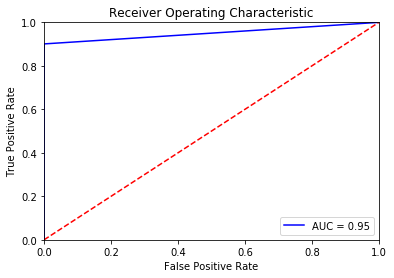

final results: 
- acc: 0.99
- F1: 0.95


In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_xgb) #calculating false positives and true positives rates
roc_auc = auc(fpr, tpr)#compute area under curve

#plot ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc) #plot fpr vs tpr
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

y_test_xgb = threshold(y_test_xgb, 0.5)#convert model test predictions to binary integer list
print("""final results: 
- acc: %.2f
- F1: %.2f""" % (accuracy_score(y_test, y_test_xgb), f1_score(y_test, y_test_xgb)))

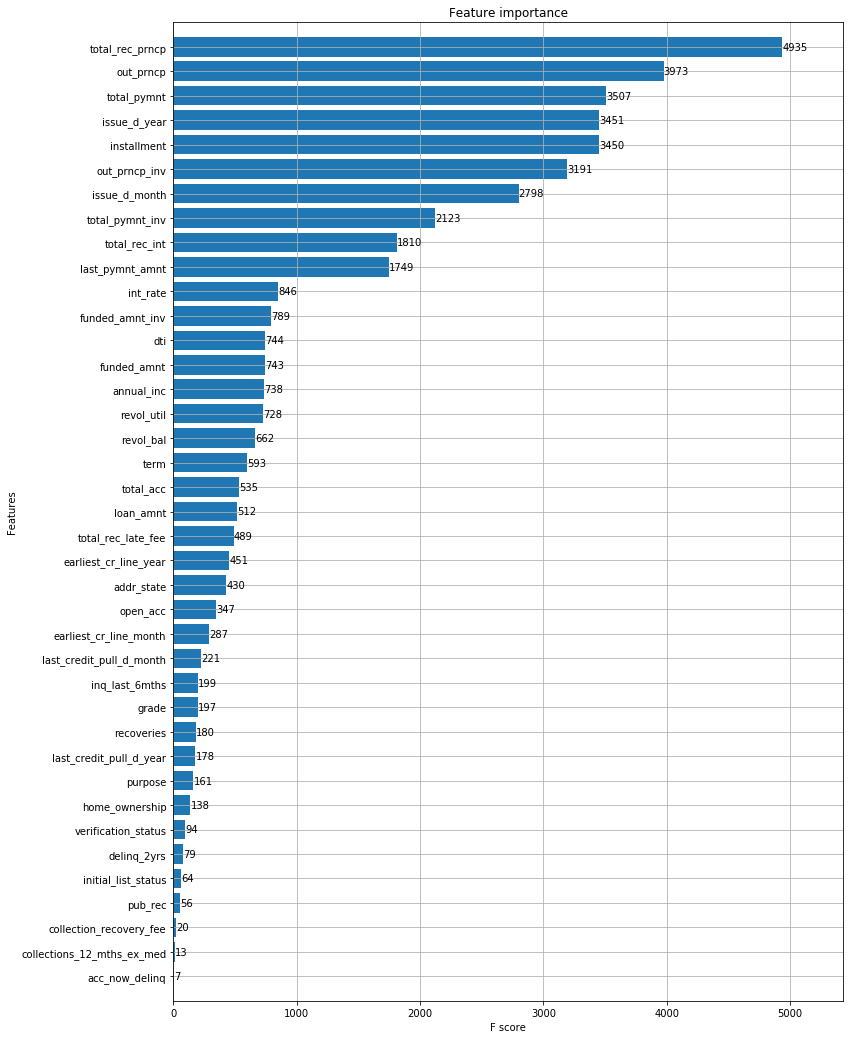

In [64]:
#plotting feature importances
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

The total recieved principal and outstanding principal are the two most important features when determining default status. This makes sense as a higher total recieved principal means that the client has been making payments towards the loan and it is less likely to default; vice-versa for outstanding principal.